# 라우터

## 라우터란?

사용자의 인풋에 따라서, Gen AI를 컨텍스트에 맞는 답변을 수행해야 하는지를 판단하게 할 수 있습니다.
이러한 작업을 수행하는 것이 라우터입니다.
그래서 사용자의 컨텍스트에 맞게 해당되는 툴로 답변을 유도하거나, LLM이 스스로 답변하는 형태로 답변하도록 합니다.

이 실습예제도 사용자의 요청에 따라서 툴을 사용하거난, LLM을 통해서 직접 답변하게는 등의 수행이 제대로 되는지를 실습해 볼 예정입니다.

이러한 라우터 방식이 동작하게 하기 위해서 아래의 2가지 형태를 준비할 예정입니다.
- 우선 툴을 사용하는 노드를 구성합니다.
- 그리고 조건부 엣지를 생성합니다. 이 조건부 엣지에서는 사용자 인풋에 따라서, 툴을 사용하게 할 것인지, LLM이 직접 답변하게 할 지 등에 대해서 라우터 역할을 수행하게 할 것입니다.

## 패키지 설치

In [9]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph

## Bedrock setup

In [10]:
import os
import boto3
from langchain_aws import ChatBedrockConverse
from langchain_aws import ChatBedrock

# ---- ⚠️ Update region for your AWS setup ⚠️ ----
aws_region = os.getenv("AWS_REGION")
bedrock_client = boto3.client("bedrock-runtime", region_name=aws_region)

llm = ChatBedrockConverse(
    model="anthropic.claude-3-haiku-20240307-v1:0",
    temperature=0,
    max_tokens=None,
    client=bedrock_client,
    # other params...
)

llm.invoke("what is the Amazon Nova?")


AIMessage(content="The Amazon Nova is a line of tablet computers developed and sold by Amazon. Some key details about the Amazon Nova tablets:\n\n- They are part of Amazon's Fire tablet lineup, which also includes the standard Fire tablets and the Fire HD tablets.\n\n- The Amazon Nova tablets are designed to be more premium and higher-end models compared to the standard Fire tablets.\n\n- They typically feature larger screen sizes, more powerful processors, more RAM, and additional storage compared to the base Fire tablets.\n\n- The Amazon Nova tablets run Amazon's Fire OS, which is a customized version of the Android operating system.\n\n- They are primarily designed to integrate with Amazon's ecosystem of services like Amazon Prime, Kindle, Alexa, and Amazon's digital content stores.\n\n- Some recent models in the Amazon Nova line include the Fire HD 10 Plus and the Fire HD 10 Productivity Edition, which are positioned as more advanced and capable tablets.\n\nSo in summary, the Amazo

## 툴 함수 생성

In [15]:
def multiply(a: int, b: int) -> int:
    """This tool is to multiply two input argrments such as a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])

## 그래프 생성

우리는 아주 쉽고 간단한 형태로 구현하는 것을 수행해 볼 것입니다.
LangGraph에서 제공하는 `ToolNode` 패키지를 이용할 것입니다.
툴노드를 사용하게 되면, 간단하게 생성된 툴들을 이 노드에서 처리하도록 할 수 있습니다.

그리고 Langgraph에서 제공하는 `tools_condition`을 조건부 엣지에서 사용할 예정입니다.
이 기능을 사용하게 되면, 사용자의 입력에 따라서 자동으로 어떤 툴들을 사용할지에 대해서 분기합니다.

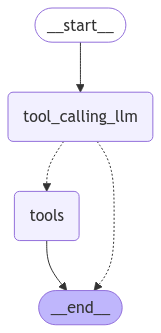

In [16]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

## 일상적인 대화로 질의

In [17]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="안녕 잘 지내?")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

안녕 잘 지내?
================================== Ai Message ==================================

네, 저도 잘 지내고 있습니다. 오늘 날씨가 좋아서 기분이 좋네요. 어떤 계획이 있으신가요? 함께 즐거운 시간을 보내면 좋겠습니다.


## 곱셈을 문의하는 질의

In [25]:
messages = [HumanMessage(content="134 곱하기 1435를 계산하면 얼마야?")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

134 곱하기 1435를 계산하면 얼마야?
================================== Ai Message ==================================

[{'type': 'tool_use', 'name': 'multiply', 'input': {'a': 134, 'b': 1435}, 'id': 'tooluse_FYpRmFUlTz6BQRNDuX6Fpg'}]
Tool Calls:
  multiply (tooluse_FYpRmFUlTz6BQRNDuX6Fpg)
 Call ID: tooluse_FYpRmFUlTz6BQRNDuX6Fpg
  Args:
    a: 134
    b: 1435
================================= Tool Message =================================
Name: multiply

192290
